In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
import random
import torch
random.seed(0) # Set seed for NumPy
np.random.seed(0) # Set seed for PyTorch (for both CPU and GPU)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_df = pd.read_csv('train_dataset/metadata.csv')
test_df = pd.read_csv('test_dataset/metadata.csv')
val_df = pd.read_csv('validation_dataset/metadata.csv')

In [ ]:
print(train_df['diagnosis'].value_counts())

diagnosis
nevus                         1205
melanoma                      1113
pigmented benign keratosis    1099
basal cell carcinoma           514
squamous cell carcinoma        197
vascular lesion                142
actinic keratosis              130
dermatofibroma                 115
Name: count, dtype: int64


In [ ]:
class_mapping = {
    "actinic keratosis": 0,
    "basal cell carcinoma": 1,
    "dermatofibroma": 2,
    "melanoma": 3,
    "nevus": 4,
    "pigmented benign keratosis": 5,
    "squamous cell carcinoma": 6,
    "vascular lesion":7
}
class_mapping

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'squamous cell carcinoma': 6,
 'vascular lesion': 7}

In [ ]:
from PIL import Image
import os

import torchvision.transforms as transforms

# Define image transformations (resize, convert to tensor, and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images to 224x224 (matching ResNet input size)
    transforms.ToTensor()
])
"""
Creating a Dataset class to read the data to pass it later to the data loader
"""
class Dataset():
    def __init__(self, dataframe, transform, train='train'):
        self.dataframe=dataframe
        self.train = train
        self.transform = transform
        self.path_to_image=self._create_path_to_image_dict()
        self.paths=list(self.path_to_image.keys())
        self.labels=list(self.path_to_image.values())

    def _create_path_to_image_dict(self):
      path_to_image={}
      for index,row in self.dataframe.iterrows():
        if self.train == 'train':
          img_path = os.path.join('train_dataset/',row['isic_id']+'.jpg')
        elif self.train == 'test':
          img_path = os.path.join('test_dataset/',row['isic_id']+'.jpg')
        else:
            img_path = os.path.join('validation_dataset/',row['isic_id']+'.jpg')
        label=row['diagnosis']
        path_to_image[img_path]=label
      return path_to_image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path=self.paths[index]
        img_label=self.labels[index]
        image=Image.open(img_path)
        image=self.transform(image)
        if self.train == 'val':
            return image, class_mapping[img_label], index
        return image, img_label, index

In [ ]:
train_df = Dataset(train_df, transform)
val_df = Dataset(val_df, transform,train='val')
test_df = Dataset(test_df, transform,train='test')

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam

# Load pre-trained ResNet50 model from torchvision
base_model = models.resnet50(pretrained=True)

num_classes = 8

"""
replacing the final fc in the pretrained base model to adjust it to the number of classes we have
"""
base_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(base_model.fc.in_features, 128),  # Add a fully connected layer
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Final layer with number of classes
    nn.Softmax(dim=1)
)

for param in base_model.parameters():
    param.requires_grad = False  # Freeze all layers except the fully connected ones

# Unfreeze the final fully connected layer
for param in base_model.fc.parameters():
    param.requires_grad = True

loss_f = nn.CrossEntropyLoss()
optimizer = Adam(base_model.fc.parameters(), lr=0.0008)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)


/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 4
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 num_epochs):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        if self.selection_criterion == 'random':
          self.train_indices = []
        self.num_epochs = num_epochs
        # self.best_acc = 0

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        for iteration in range(self.iterations):
            print(f"--------- Number of Iteration {iteration} ---------")
            if self.selection_criterion == 'random':
                self._random_sampling()
            elif self.selection_criterion == 'BADGE_30':
                self._badge_sampling()
            else:
              self._custom_sampling(iteration)

            train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
            label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
            self._train_model(train_images, label_df)
            #loading the best model weights in each iteration
            self.model.load_state_dict(torch.load(f"best_{self.selection_criterion}_model.pth"))
            accuracy = self._evaluate_model()
            accuracy_scores.append(accuracy)
        return accuracy_scores

    def calculate_class_weights(self, label_counts, num_classes=8):
        """
        this function is to caculate the inverse probability of each class in the data
        """
        total_samples = sum(label_counts.values())
        class_weights = torch.zeros(num_classes)

        for cls in range(num_classes):
            if cls in label_counts:
                class_weights[cls] = total_samples / (num_classes * label_counts[cls])
            else:
                class_weights[cls] = 1.0  # Handle the case where a class has zero samples in the current epoch

        return class_weights

    def _train_model(self, train_images, label_df):
      label_counts = defaultdict(int)
      for label in label_df:
                label_counts[label] += 1
      class_weights = self.calculate_class_weights(label_counts, 8).to(device)
      #giving higher weight for the loss of samples that their class is a minority in the data while giving less weight
      #to the loss for classes that are majority
      loss_f = nn.CrossEntropyLoss(weight=class_weights)

      train_images_tensor = torch.stack(train_images)
      label_df_tensor = torch.tensor(label_df)
      train_dataset = TensorDataset(train_images_tensor, label_df_tensor)

      batch_size = 32
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      best_acc = 0
      for epoch in range(self.num_epochs):
                self.model.train()
                running_loss = 0.0  # Track the running loss
                correct_predictions = 0
                total_predictions = 0
                # Training loop
                for inputs, labels in train_loader:
                    inputs = inputs
                    inputs= inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)
                    # outputs = outputs.logits
                    loss = loss_f(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    # Calculate accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_predictions += torch.sum(preds == labels)
                    total_predictions += inputs.shape[0]

                # Print loss and accuracy at the end of each epoch
                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct_predictions.double() / total_predictions
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
                #saving the best model weights on the validation
                val_acc = self._check_model()
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(self.model.state_dict(), f"best_{self.selection_criterion}_model.pth")
      print("--"*30)

    def _check_model(self):
        """
        this function is used to evaluate the model on the validation set
        """
        self.model.eval()
        running_corrects = 0
        total_predictions = 0.0

        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = model(inputs)
                # outputs = outputs.logits
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        val_acc = running_corrects.double() / total_predictions
        return val_acc.item()

    def _evaluate_model(self):
        """
        Evaluate the model on the test set
        :return:
        accuracy: float, accuracy of the model
        """
        self.model.eval()
        running_corrects = 0
        test_images_tensor = torch.stack(test_images)
        label_df_tensor = torch.tensor(test_label_df)
        test_dataset = TensorDataset(test_images_tensor, label_df_tensor)
        batch_size = 32
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        total_predictions = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        test_acc = running_corrects.double() / total_predictions
        return test_acc.item()

    def _random_sampling(self):
      """
      random sampling strategy
      """
      selected_indices = np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
      selected_indices = selected_indices.tolist()
      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)


    def _badge_sampling(self):
      """
      BADGE sampling strategy
      """
      model = self.model

      X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]

      pool_images_tensor = torch.stack(X_unlabeled)
      pool_dataset = TensorDataset(pool_images_tensor)

      batch_size = 32
      pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)
      model.eval()
      gradient_embeddings = []

      def extract_grad_hook(module, grad_input, grad_output):
        gradient_embeddings.append(grad_output[0].detach().cpu().numpy())
      #calculating the gradients based on the last layer of the model
      handle = model.fc[3].register_full_backward_hook(extract_grad_hook)

      for inputs in pool_loader:
        inputs = inputs[0].to(device)
        inputs.requires_grad = False
        outputs = model(inputs)

        predicted_labels = torch.argmax(outputs, dim=1).to(device)
        loss = torch.nn.functional.cross_entropy(outputs, predicted_labels)

        model.zero_grad()

        loss.backward()
      handle.remove()

      gradient_embeddings = np.concatenate(gradient_embeddings, axis=0)
      num_samples_to_select = self.budget_per_iter
      #applying KMenas++ on the gradients embeddings
      kmeans = KMeans(n_clusters=num_samples_to_select, init='k-means++', random_state=0).fit(gradient_embeddings)
      #updating the pool and train indices
      centroids = kmeans.cluster_centers_
      selected_indices = []
      for i in range(num_samples_to_select):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        closest_sample_index = min(cluster_indices, key=lambda idx: np.linalg.norm(gradient_embeddings[idx] - centroids[i]))
        selected_indices.append(closest_sample_index)

      temp = np.array(self.available_pool_indices)
      selected_indices = temp[selected_indices]

      self.train_indices = self.train_indices + selected_indices.tolist()

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)


In [ ]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
available_pool_indices = []
for i in range(len(train_df)):
    image, label, index = train_df[i]
    available_pool_indices.append(index)

test_indices = []
for i in range(len(test_df)):
    image, label, index = test_df[i]
    test_indices.append(index)
test_images = [test_df.__getitem__(index)[0] for index in test_indices]
test_label_df = [class_mapping[test_df.__getitem__(index)[1]] for index in test_indices]

In [ ]:
#According to the initialization that we got using KMeans++ Code of the initialization could be found in the initialization file
train_indices = [1372,
 1277,
 1255,
 1423,
 2925,
 1963,
 2335,
 1923,
 3791,
 1239,
 909,
 134,
 1547,
 3931,
 2467,
 2832,
 1789,
 3022,
 2424,
 780,
 2412,
 3038,
 2158,
 3335,
 1868,
 1771,
 2015,
 1535,
 710,
 3007]
available_pool_set = set(available_pool_indices)
train_set = set(train_indices)
available_pool_indices = list(available_pool_set - train_set)

In [ ]:
iterations = 20
budget_per_iter = 60 #30
num_epoch = 15
selection_criteria = ['BADGE'] # BADGE_30
accuracy_scores_dict = defaultdict(list)
model = base_model

--------- Number of Iteration 0 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 2.0804, Accuracy: 0.0500


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 2.0274, Accuracy: 0.3167
Epoch [3/15], Loss: 1.9875, Accuracy: 0.3500
Epoch [4/15], Loss: 1.9434, Accuracy: 0.4333
Epoch [5/15], Loss: 1.9091, Accuracy: 0.4167
Epoch [6/15], Loss: 1.8228, Accuracy: 0.4500
Epoch [7/15], Loss: 1.8067, Accuracy: 0.6500
Epoch [8/15], Loss: 1.7432, Accuracy: 0.7667
Epoch [9/15], Loss: 1.7027, Accuracy: 0.8667
Epoch [10/15], Loss: 1.6765, Accuracy: 0.8500
Epoch [11/15], Loss: 1.6206, Accuracy: 0.9000
Epoch [12/15], Loss: 1.5688, Accuracy: 0.9000
Epoch [13/15], Loss: 1.5271, Accuracy: 0.8833
Epoch [14/15], Loss: 1.5257, Accuracy: 0.9000
Epoch [15/15], Loss: 1.4706, Accuracy: 0.9333
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 1 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.7231, Accuracy: 0.7667


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.7098, Accuracy: 0.7889
Epoch [3/15], Loss: 1.6936, Accuracy: 0.7667
Epoch [4/15], Loss: 1.6472, Accuracy: 0.7889
Epoch [5/15], Loss: 1.6702, Accuracy: 0.7889
Epoch [6/15], Loss: 1.6448, Accuracy: 0.8111
Epoch [7/15], Loss: 1.6054, Accuracy: 0.8333
Epoch [8/15], Loss: 1.6308, Accuracy: 0.8556
Epoch [9/15], Loss: 1.6305, Accuracy: 0.8556
Epoch [10/15], Loss: 1.6046, Accuracy: 0.8444
Epoch [11/15], Loss: 1.6168, Accuracy: 0.8333
Epoch [12/15], Loss: 1.5965, Accuracy: 0.8556
Epoch [13/15], Loss: 1.6027, Accuracy: 0.8778
Epoch [14/15], Loss: 1.5947, Accuracy: 0.8778
Epoch [15/15], Loss: 1.5936, Accuracy: 0.8556
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 2 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6947, Accuracy: 0.7417


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6659, Accuracy: 0.7333
Epoch [3/15], Loss: 1.6554, Accuracy: 0.7500
Epoch [4/15], Loss: 1.6518, Accuracy: 0.7667
Epoch [5/15], Loss: 1.6304, Accuracy: 0.7833
Epoch [6/15], Loss: 1.6158, Accuracy: 0.7833
Epoch [7/15], Loss: 1.6334, Accuracy: 0.8000
Epoch [8/15], Loss: 1.6260, Accuracy: 0.7667
Epoch [9/15], Loss: 1.6116, Accuracy: 0.8250
Epoch [10/15], Loss: 1.6217, Accuracy: 0.7917
Epoch [11/15], Loss: 1.5990, Accuracy: 0.8000
Epoch [12/15], Loss: 1.6027, Accuracy: 0.8250
Epoch [13/15], Loss: 1.5945, Accuracy: 0.8500
Epoch [14/15], Loss: 1.5944, Accuracy: 0.8083
Epoch [15/15], Loss: 1.5577, Accuracy: 0.8333
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 3 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6392, Accuracy: 0.7000


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6259, Accuracy: 0.7333
Epoch [3/15], Loss: 1.6386, Accuracy: 0.7400
Epoch [4/15], Loss: 1.6368, Accuracy: 0.7667
Epoch [5/15], Loss: 1.6233, Accuracy: 0.7467
Epoch [6/15], Loss: 1.5991, Accuracy: 0.7867
Epoch [7/15], Loss: 1.6183, Accuracy: 0.7800
Epoch [8/15], Loss: 1.6076, Accuracy: 0.8200
Epoch [9/15], Loss: 1.6118, Accuracy: 0.8000
Epoch [10/15], Loss: 1.6023, Accuracy: 0.8000
Epoch [11/15], Loss: 1.6128, Accuracy: 0.7933
Epoch [12/15], Loss: 1.5985, Accuracy: 0.8400
Epoch [13/15], Loss: 1.5720, Accuracy: 0.8267
Epoch [14/15], Loss: 1.5631, Accuracy: 0.8400
Epoch [15/15], Loss: 1.6025, Accuracy: 0.8133
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 4 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6701, Accuracy: 0.7167


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6468, Accuracy: 0.7333
Epoch [3/15], Loss: 1.6368, Accuracy: 0.7611
Epoch [4/15], Loss: 1.6430, Accuracy: 0.7778
Epoch [5/15], Loss: 1.6404, Accuracy: 0.7667
Epoch [6/15], Loss: 1.6411, Accuracy: 0.8000
Epoch [7/15], Loss: 1.6286, Accuracy: 0.7833
Epoch [8/15], Loss: 1.6508, Accuracy: 0.7389
Epoch [9/15], Loss: 1.6063, Accuracy: 0.8056
Epoch [10/15], Loss: 1.6229, Accuracy: 0.7889
Epoch [11/15], Loss: 1.6116, Accuracy: 0.8278
Epoch [12/15], Loss: 1.5990, Accuracy: 0.7778
Epoch [13/15], Loss: 1.6221, Accuracy: 0.8000
Epoch [14/15], Loss: 1.6107, Accuracy: 0.8278
Epoch [15/15], Loss: 1.5974, Accuracy: 0.8111
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 5 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6589, Accuracy: 0.7286


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6826, Accuracy: 0.6952
Epoch [3/15], Loss: 1.6571, Accuracy: 0.7381
Epoch [4/15], Loss: 1.6378, Accuracy: 0.7571
Epoch [5/15], Loss: 1.6388, Accuracy: 0.7857
Epoch [6/15], Loss: 1.6270, Accuracy: 0.7524
Epoch [7/15], Loss: 1.6075, Accuracy: 0.7952
Epoch [8/15], Loss: 1.6100, Accuracy: 0.7952
Epoch [9/15], Loss: 1.6041, Accuracy: 0.8238
Epoch [10/15], Loss: 1.6274, Accuracy: 0.8190
Epoch [11/15], Loss: 1.6034, Accuracy: 0.8095
Epoch [12/15], Loss: 1.5797, Accuracy: 0.8429
Epoch [13/15], Loss: 1.5735, Accuracy: 0.8381
Epoch [14/15], Loss: 1.5629, Accuracy: 0.8571
Epoch [15/15], Loss: 1.5702, Accuracy: 0.8619
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 6 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6710, Accuracy: 0.7458


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6803, Accuracy: 0.7167
Epoch [3/15], Loss: 1.6746, Accuracy: 0.7375
Epoch [4/15], Loss: 1.6491, Accuracy: 0.7583
Epoch [5/15], Loss: 1.6394, Accuracy: 0.7583
Epoch [6/15], Loss: 1.6364, Accuracy: 0.8042
Epoch [7/15], Loss: 1.6282, Accuracy: 0.7458
Epoch [8/15], Loss: 1.6138, Accuracy: 0.8042
Epoch [9/15], Loss: 1.6229, Accuracy: 0.8042
Epoch [10/15], Loss: 1.5916, Accuracy: 0.7875
Epoch [11/15], Loss: 1.5819, Accuracy: 0.7667
Epoch [12/15], Loss: 1.5739, Accuracy: 0.8417
Epoch [13/15], Loss: 1.5687, Accuracy: 0.8417
Epoch [14/15], Loss: 1.5581, Accuracy: 0.7917
Epoch [15/15], Loss: 1.5377, Accuracy: 0.8208
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 7 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6372, Accuracy: 0.7370


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6351, Accuracy: 0.7667
Epoch [3/15], Loss: 1.6035, Accuracy: 0.7741
Epoch [4/15], Loss: 1.5867, Accuracy: 0.7815
Epoch [5/15], Loss: 1.5983, Accuracy: 0.7667
Epoch [6/15], Loss: 1.5712, Accuracy: 0.7963
Epoch [7/15], Loss: 1.5685, Accuracy: 0.7481
Epoch [8/15], Loss: 1.5641, Accuracy: 0.8000
Epoch [9/15], Loss: 1.5294, Accuracy: 0.8148
Epoch [10/15], Loss: 1.5227, Accuracy: 0.8556
Epoch [11/15], Loss: 1.5219, Accuracy: 0.8259
Epoch [12/15], Loss: 1.5350, Accuracy: 0.8259
Epoch [13/15], Loss: 1.5167, Accuracy: 0.7852
Epoch [14/15], Loss: 1.5229, Accuracy: 0.8444
Epoch [15/15], Loss: 1.4988, Accuracy: 0.8185
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 8 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6496, Accuracy: 0.7000


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6248, Accuracy: 0.7633
Epoch [3/15], Loss: 1.6421, Accuracy: 0.7200
Epoch [4/15], Loss: 1.6077, Accuracy: 0.7833
Epoch [5/15], Loss: 1.6089, Accuracy: 0.7100
Epoch [6/15], Loss: 1.5761, Accuracy: 0.7500
Epoch [7/15], Loss: 1.5662, Accuracy: 0.7700
Epoch [8/15], Loss: 1.5563, Accuracy: 0.7600
Epoch [9/15], Loss: 1.5389, Accuracy: 0.8000
Epoch [10/15], Loss: 1.5110, Accuracy: 0.7900
Epoch [11/15], Loss: 1.5174, Accuracy: 0.7700
Epoch [12/15], Loss: 1.5196, Accuracy: 0.8167
Epoch [13/15], Loss: 1.5572, Accuracy: 0.7367
Epoch [14/15], Loss: 1.5038, Accuracy: 0.8233
Epoch [15/15], Loss: 1.4922, Accuracy: 0.8300
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 9 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5818, Accuracy: 0.7606


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5730, Accuracy: 0.7576
Epoch [3/15], Loss: 1.5920, Accuracy: 0.7545
Epoch [4/15], Loss: 1.5628, Accuracy: 0.7545
Epoch [5/15], Loss: 1.5662, Accuracy: 0.7333
Epoch [6/15], Loss: 1.5697, Accuracy: 0.7879
Epoch [7/15], Loss: 1.5514, Accuracy: 0.7667
Epoch [8/15], Loss: 1.5577, Accuracy: 0.7758
Epoch [9/15], Loss: 1.5423, Accuracy: 0.7576
Epoch [10/15], Loss: 1.5571, Accuracy: 0.8030
Epoch [11/15], Loss: 1.5336, Accuracy: 0.8121
Epoch [12/15], Loss: 1.5380, Accuracy: 0.8061
Epoch [13/15], Loss: 1.5067, Accuracy: 0.8061
Epoch [14/15], Loss: 1.5294, Accuracy: 0.8182
Epoch [15/15], Loss: 1.5447, Accuracy: 0.7970
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 10 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5888, Accuracy: 0.7639


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5680, Accuracy: 0.7861
Epoch [3/15], Loss: 1.5878, Accuracy: 0.7472
Epoch [4/15], Loss: 1.5520, Accuracy: 0.7806
Epoch [5/15], Loss: 1.5227, Accuracy: 0.7889
Epoch [6/15], Loss: 1.4759, Accuracy: 0.8306
Epoch [7/15], Loss: 1.5094, Accuracy: 0.8056
Epoch [8/15], Loss: 1.5348, Accuracy: 0.7639
Epoch [9/15], Loss: 1.5360, Accuracy: 0.7417
Epoch [10/15], Loss: 1.4653, Accuracy: 0.7889
Epoch [11/15], Loss: 1.4511, Accuracy: 0.8417
Epoch [12/15], Loss: 1.4651, Accuracy: 0.7889
Epoch [13/15], Loss: 1.4293, Accuracy: 0.8444
Epoch [14/15], Loss: 1.4144, Accuracy: 0.8444
Epoch [15/15], Loss: 1.4393, Accuracy: 0.8306
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 11 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5718, Accuracy: 0.7513


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5226, Accuracy: 0.7821
Epoch [3/15], Loss: 1.4779, Accuracy: 0.8282
Epoch [4/15], Loss: 1.4938, Accuracy: 0.8308
Epoch [5/15], Loss: 1.4620, Accuracy: 0.7769
Epoch [6/15], Loss: 1.4985, Accuracy: 0.8205
Epoch [7/15], Loss: 1.5060, Accuracy: 0.8000
Epoch [8/15], Loss: 1.4579, Accuracy: 0.8103
Epoch [9/15], Loss: 1.5031, Accuracy: 0.7692
Epoch [10/15], Loss: 1.4783, Accuracy: 0.7615
Epoch [11/15], Loss: 1.4379, Accuracy: 0.8385
Epoch [12/15], Loss: 1.4568, Accuracy: 0.7615
Epoch [13/15], Loss: 1.4213, Accuracy: 0.8436
Epoch [14/15], Loss: 1.4501, Accuracy: 0.8308
Epoch [15/15], Loss: 1.4178, Accuracy: 0.8513
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 12 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4968, Accuracy: 0.7905


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5288, Accuracy: 0.7286
Epoch [3/15], Loss: 1.5495, Accuracy: 0.7452
Epoch [4/15], Loss: 1.5397, Accuracy: 0.7690
Epoch [5/15], Loss: 1.5054, Accuracy: 0.7952
Epoch [6/15], Loss: 1.4969, Accuracy: 0.8190
Epoch [7/15], Loss: 1.4921, Accuracy: 0.8167
Epoch [8/15], Loss: 1.5033, Accuracy: 0.7667
Epoch [9/15], Loss: 1.4437, Accuracy: 0.8119
Epoch [10/15], Loss: 1.4394, Accuracy: 0.8262
Epoch [11/15], Loss: 1.5086, Accuracy: 0.7452
Epoch [12/15], Loss: 1.4766, Accuracy: 0.7810
Epoch [13/15], Loss: 1.4580, Accuracy: 0.8167
Epoch [14/15], Loss: 1.4587, Accuracy: 0.8095
Epoch [15/15], Loss: 1.4857, Accuracy: 0.7976
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 13 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5221, Accuracy: 0.7489


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5579, Accuracy: 0.7756
Epoch [3/15], Loss: 1.5113, Accuracy: 0.7933
Epoch [4/15], Loss: 1.5145, Accuracy: 0.7933
Epoch [5/15], Loss: 1.5113, Accuracy: 0.7467
Epoch [6/15], Loss: 1.4938, Accuracy: 0.8422
Epoch [7/15], Loss: 1.5477, Accuracy: 0.6889
Epoch [8/15], Loss: 1.6212, Accuracy: 0.6289
Epoch [9/15], Loss: 1.4961, Accuracy: 0.7489
Epoch [10/15], Loss: 1.5068, Accuracy: 0.7778
Epoch [11/15], Loss: 1.4846, Accuracy: 0.8333
Epoch [12/15], Loss: 1.4842, Accuracy: 0.8289
Epoch [13/15], Loss: 1.4209, Accuracy: 0.8267
Epoch [14/15], Loss: 1.4642, Accuracy: 0.8333
Epoch [15/15], Loss: 1.4990, Accuracy: 0.7400
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 14 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5148, Accuracy: 0.7167


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4857, Accuracy: 0.7625
Epoch [3/15], Loss: 1.4751, Accuracy: 0.7833
Epoch [4/15], Loss: 1.4545, Accuracy: 0.7917
Epoch [5/15], Loss: 1.4582, Accuracy: 0.7979
Epoch [6/15], Loss: 1.4668, Accuracy: 0.7792
Epoch [7/15], Loss: 1.4471, Accuracy: 0.7958
Epoch [8/15], Loss: 1.4469, Accuracy: 0.8083
Epoch [9/15], Loss: 1.4515, Accuracy: 0.8063
Epoch [10/15], Loss: 1.4378, Accuracy: 0.8167
Epoch [11/15], Loss: 1.4438, Accuracy: 0.8208
Epoch [12/15], Loss: 1.4326, Accuracy: 0.8292
Epoch [13/15], Loss: 1.4255, Accuracy: 0.8208
Epoch [14/15], Loss: 1.4212, Accuracy: 0.8458
Epoch [15/15], Loss: 1.4193, Accuracy: 0.8312
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 15 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4491, Accuracy: 0.8020


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4593, Accuracy: 0.7824
Epoch [3/15], Loss: 1.4478, Accuracy: 0.8039
Epoch [4/15], Loss: 1.4494, Accuracy: 0.7922
Epoch [5/15], Loss: 1.4494, Accuracy: 0.8020
Epoch [6/15], Loss: 1.4295, Accuracy: 0.8353
Epoch [7/15], Loss: 1.4540, Accuracy: 0.7882
Epoch [8/15], Loss: 1.4369, Accuracy: 0.8059
Epoch [9/15], Loss: 1.4346, Accuracy: 0.8157
Epoch [10/15], Loss: 1.4347, Accuracy: 0.8137
Epoch [11/15], Loss: 1.4183, Accuracy: 0.8333
Epoch [12/15], Loss: 1.4294, Accuracy: 0.8196
Epoch [13/15], Loss: 1.4198, Accuracy: 0.8333
Epoch [14/15], Loss: 1.4245, Accuracy: 0.8098
Epoch [15/15], Loss: 1.4247, Accuracy: 0.8314
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 16 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4444, Accuracy: 0.8148


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4416, Accuracy: 0.8148
Epoch [3/15], Loss: 1.4447, Accuracy: 0.7704
Epoch [4/15], Loss: 1.4551, Accuracy: 0.7889
Epoch [5/15], Loss: 1.4293, Accuracy: 0.8074
Epoch [6/15], Loss: 1.4265, Accuracy: 0.8111
Epoch [7/15], Loss: 1.4254, Accuracy: 0.8315
Epoch [8/15], Loss: 1.4156, Accuracy: 0.8130
Epoch [9/15], Loss: 1.4270, Accuracy: 0.8296
Epoch [10/15], Loss: 1.4183, Accuracy: 0.8278
Epoch [11/15], Loss: 1.4457, Accuracy: 0.8037
Epoch [12/15], Loss: 1.4128, Accuracy: 0.8296
Epoch [13/15], Loss: 1.4222, Accuracy: 0.8167
Epoch [14/15], Loss: 1.3983, Accuracy: 0.8593
Epoch [15/15], Loss: 1.3975, Accuracy: 0.8500
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 17 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4625, Accuracy: 0.7895


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4614, Accuracy: 0.7930
Epoch [3/15], Loss: 1.4699, Accuracy: 0.7614
Epoch [4/15], Loss: 1.4636, Accuracy: 0.7789
Epoch [5/15], Loss: 1.4634, Accuracy: 0.7825
Epoch [6/15], Loss: 1.4569, Accuracy: 0.7965
Epoch [7/15], Loss: 1.4618, Accuracy: 0.7789
Epoch [8/15], Loss: 1.4384, Accuracy: 0.8140
Epoch [9/15], Loss: 1.4215, Accuracy: 0.8281
Epoch [10/15], Loss: 1.4488, Accuracy: 0.7754
Epoch [11/15], Loss: 1.4319, Accuracy: 0.8140
Epoch [12/15], Loss: 1.4075, Accuracy: 0.8368
Epoch [13/15], Loss: 1.4110, Accuracy: 0.8316
Epoch [14/15], Loss: 1.4130, Accuracy: 0.8333
Epoch [15/15], Loss: 1.4163, Accuracy: 0.8263
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 18 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4689, Accuracy: 0.7650


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4791, Accuracy: 0.7600
Epoch [3/15], Loss: 1.4702, Accuracy: 0.7883
Epoch [4/15], Loss: 1.4549, Accuracy: 0.7817
Epoch [5/15], Loss: 1.4609, Accuracy: 0.8017
Epoch [6/15], Loss: 1.4377, Accuracy: 0.8000
Epoch [7/15], Loss: 1.4588, Accuracy: 0.7783
Epoch [8/15], Loss: 1.4500, Accuracy: 0.7717
Epoch [9/15], Loss: 1.4428, Accuracy: 0.7933
Epoch [10/15], Loss: 1.4414, Accuracy: 0.8117
Epoch [11/15], Loss: 1.4458, Accuracy: 0.7850
Epoch [12/15], Loss: 1.4242, Accuracy: 0.8267
Epoch [13/15], Loss: 1.4462, Accuracy: 0.7783
Epoch [14/15], Loss: 1.4423, Accuracy: 0.7750
Epoch [15/15], Loss: 1.4147, Accuracy: 0.8217
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 19 ---------


/tmp/ipykernel_20979/2865371390.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4719, Accuracy: 0.7825


/tmp/ipykernel_20979/2865371390.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4615, Accuracy: 0.7937
Epoch [3/15], Loss: 1.4686, Accuracy: 0.7492
Epoch [4/15], Loss: 1.4664, Accuracy: 0.7540
Epoch [5/15], Loss: 1.4627, Accuracy: 0.7587
Epoch [6/15], Loss: 1.4451, Accuracy: 0.7825
Epoch [7/15], Loss: 1.4449, Accuracy: 0.8063
Epoch [8/15], Loss: 1.4421, Accuracy: 0.8063
Epoch [9/15], Loss: 1.4220, Accuracy: 0.7937
Epoch [10/15], Loss: 1.4528, Accuracy: 0.8032
Epoch [11/15], Loss: 1.4383, Accuracy: 0.8016
Epoch [12/15], Loss: 1.4541, Accuracy: 0.7794
Epoch [13/15], Loss: 1.4155, Accuracy: 0.8270
Epoch [14/15], Loss: 1.4350, Accuracy: 0.8063
Epoch [15/15], Loss: 1.4247, Accuracy: 0.8175
------------------------------------------------------------


/tmp/ipykernel_20979/2865371390.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


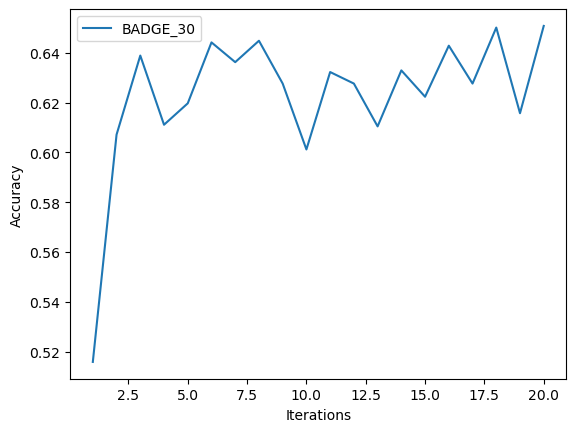

In [ ]:
for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      num_epochs=num_epoch)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)

In [ ]:
accuracy_scores_dict

defaultdict(list,
            {'BADGE_30': [0.5158730158730158,
              0.6071428571428571,
              0.6388888888888888,
              0.611111111111111,
              0.6197089947089947,
              0.6441798941798942,
              0.6362433862433862,
              0.6448412698412698,
              0.6276455026455026,
              0.6011904761904762,
              0.6322751322751322,
              0.6276455026455026,
              0.6104497354497355,
              0.6329365079365079,
              0.6223544973544973,
              0.6428571428571428,
              0.6276455026455026,
              0.6501322751322751,
              0.6157407407407407,
              0.6507936507936507]})